# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os

import torch
from src.visualize import plot_two_turbine_results

from pyomo.environ import value


#from src.visualize import plot_optimization_results

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl



## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_deterministic270.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,50.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,100.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,150.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,200.0,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [3]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [11]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2","wind_speed", "wind_direction", "turbulence_intensity"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

# Load a pre-trained model from the /models directory

# Retrain the model with the best parameters
model_nn, preds_test, y_test = cl_tool.train(n_hidden=2, n_nodes=8, iters=5000, drop=0.05, learning_rate=1e-4)

#model_nn = cl_tool.load_model(path="models/nn_deterministic_2hidden_10nodes.pth")

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 0.8334409594535828
epoch 500 loss 0.29810094833374023
epoch 1000 loss 0.10481453686952591
epoch 1500 loss 0.0578952394425869
epoch 2000 loss 0.03637910634279251
epoch 2500 loss 0.023264143615961075
epoch 3000 loss 0.016794567927718163
epoch 3500 loss 0.01296603586524725
epoch 4000 loss 0.010919341817498207
epoch 4500 loss 0.009584658779203892
NN fitting process finished with a validation MSE loss of 0.009087611921131611 in epoch 4691


In [18]:
torch.save(model_nn, "models/nn_deterministic_2hidden_8nodes.pth")

In [12]:
cons = cl_tool.constraint_build(model_nn)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7
0,-0.094017,0,0,-0.003348,0.239905,-0.368077,-0.437524,-0.418163,NaN,NaN,NaN
1,0.285588,0,1,0.119924,-0.008861,0.354591,-0.491001,0.704684,NaN,NaN,NaN
2,-0.336680,0,2,-0.135154,-0.087907,-0.427245,-0.462464,-0.323640,NaN,NaN,NaN
3,-0.776530,0,3,0.016566,0.176799,0.268338,-0.398944,-0.417395,NaN,NaN,NaN
4,-0.260838,0,4,0.162436,0.371361,-0.092037,-0.080078,-0.420122,NaN,NaN,NaN
5,-0.582320,0,5,0.047322,0.404941,-0.414867,-0.412189,-0.314308,NaN,NaN,NaN
6,0.270315,0,6,-0.174324,0.386393,-0.289875,-0.307153,-0.183519,NaN,NaN,NaN
7,0.624586,0,7,-0.418843,-0.261057,0.384424,-0.312197,0.737821,NaN,NaN,NaN
0,-0.312901,1,0,-0.200823,0.033115,0.104736,0.189732,-0.125671,-0.093951,0.163341,-0.120327
1,0.539026,1,1,0.131514,-0.152517,-0.052779,-0.803853,-0.070379,-0.036640,-0.336592,0.106183


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [13]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

contextual_sample = data[["x_turb2", "y_turb2","wind_speed",  "wind_direction", "turbulence_intensity"]].iloc[[0]]
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # model output

model.power = pyo.Var(within=pyo.Reals) # saving power per scenario

model.min_dist = pyo.Param(initialize=100, mutable=False)
model.x_max = pyo.Param(initialize=4000, mutable=False)
model.y_max = pyo.Param(initialize=500, mutable=False)

# obj function 
def obj_expression(model):
    return model.power
model.obj = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model):
    return model.power == model.y['power', 0, 1]
model.const_power = pyo.Constraint(rule=power)

#constraint for fixing contextual information
def fix_vars(model,x_ind):
    if x_ind=='x_turb2':
        return pyo.Constraint.Skip
    if x_ind=='y_turb2':
        return pyo.Constraint.Skip
    else:
        return model.x[x_ind] == contextual_sample.loc[0,x_ind]
model.const_fix_vars = pyo.Constraint(model.var_ind, rule=fix_vars)

# upper limits for x_turb2 and y_turb2
model.x_turb2_ub = pyo.Constraint(expr=model.x['x_turb2'] <= model.x_max)  # Upper bound
model.y_turb2_ub = pyo.Constraint(expr=model.x['y_turb2'] <= model.y_max)   # Upper bound

# lower limits for x_turb2 and y_turb2
model.x_turb2_lb = pyo.Constraint(expr=model.x['x_turb2'] >= 0)  # Lower bound
model.y_turb2_lb = pyo.Constraint(expr=model.x['y_turb2'] >= 0)   # Lower bound

# lower limits for x_turb2 and y_turb2
def distance_constraint(model):
    return ((model.x["x_turb2"] - 0)**2 + (model.x["y_turb2"] - 0)**2) >= model.min_dist**2 
model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed(opt_model=model, constaints=cons, outcome='power', deterministic = True)


Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power


In [14]:
# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpqul5a98_.pyomo.lp
Reading time = 0.00 seconds
x1: 58 rows, 40 columns, 308 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.5.0 24F74)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 58 rows, 40 columns and 308 nonzeros
Model fingerprint: 0x559e833b
Model has 1 quadratic constraint
Variable types: 24 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [6e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 4e+03]
  QRHS range       [1e+04, 1e+04]
Presolve removed 12 rows and 8 columns
Presolve time: 0.00s
Presolved: 49 rows, 35 columns, 249 n


Optimization Results:

Contextual/Decision Variables (x):
turbulence_intensity: 0.06
wind_direction: 270.0
wind_speed: 8.0
x_turb2: 0.0
y_turb2: 500.0
Optimal objective value: 3514.3988787802946


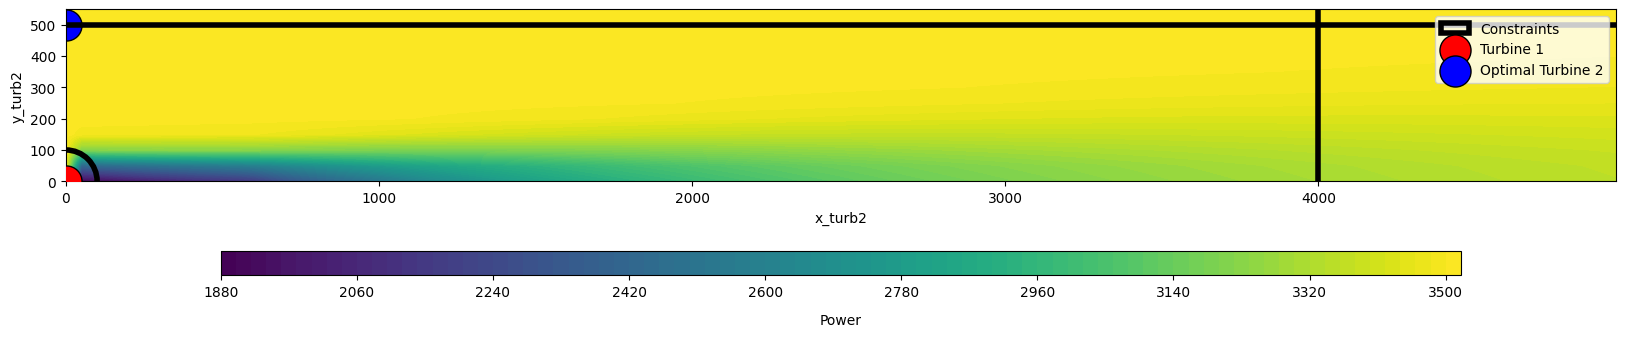

In [15]:
# get resulsts
plot_two_turbine_results(data, zfeature='farm_power', model_opt=model)


print("\nOptimization Results:")
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")
print("Optimal objective value:", value(model.obj))


In [16]:
# verify obj function value is correct
cl_tool.predict(X=pd.DataFrame({
    "x_turb2": [value(model.x["x_turb2"])],
    "y_turb2": [value(model.x["y_turb2"])],
    "wind_speed": [contextual_sample.loc[0, "wind_speed"]],
    "wind_direction": [contextual_sample.loc[0, "wind_direction"]],
    "turbulence_intensity": [contextual_sample.loc[0, "turbulence_intensity"]]
}))

array([[3514.399]], dtype=float32)